In [37]:

import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output

from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

"run_field_sequence" that randomly generates and simulates a set of fields. It returns the time, DW position and angle plus the input time sequence.
field_low and field_high specify the range the fields will be generated over while N_fields is the number of fields in the sequence and T is the time period of each field.

The outputs of interest are t, y and h_t. y[0] is the DW position over time (at time points given in t) and h_t is the magnetic field (serves as input) at the same times.

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [39]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [0.0,0.0])

[100.]
[100.]


In [40]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((1000,), (2, 1000), (1000,), (1,), (1,))

In [41]:
fields,periods

(array([100.]), array([100.]))

In [42]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(3, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,3)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        

    def forward(self, t,x):
        x = self.lrelu(self.lin(x))
        x = self.lrelu(self.lin2(x))
        x = self.tanh(self.lin3(x))
        x = self.lin4(x)
        return x
     

In [43]:
class DWODE_1(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE_1, self).__init__()
        self.lin = nn.Linear(3, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,1024)
        self.lin5 = nn.Linear(1024,3)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        

    def forward(self, t,x):
        x = self.lrelu(self.lin(x))
        x = self.lrelu(self.lin2(x))
        x = self.lrelu(self.lin3(x))
        x = self.lrelu(self.lin4(x))
        x = self.lin5(x)
        return x
     

In [44]:
time = torch.tensor(t).to(device)

In [45]:
time.shape

torch.Size([1000])

In [46]:
time_train = torch.tensor(t).to(device)

In [47]:
time_test = torch.tensor(t[300:]).to(device)

In [48]:
time_train.shape,time_test.shape

(torch.Size([1000]), torch.Size([700]))

In [49]:
h_t_ = torch.tensor(h_t, dtype=torch.float64)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(h_t_, 1000.),torch.div(y_0_, 1000.),y_1_)).to(device)

In [50]:
data.shape

torch.Size([3, 1000])

In [51]:
train = data[:,:].transpose(0,1)

In [52]:
test = data[:,300:].transpose(0,1)

In [53]:
train.shape,test.shape

(torch.Size([1000, 3]), torch.Size([700, 3]))

In [54]:
model = DWODE_1().double().to(device)

In [55]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [56]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [57]:
from torchdiffeq import odeint_adjoint as adjoint

Iter 0900 | Total Loss 0.002054


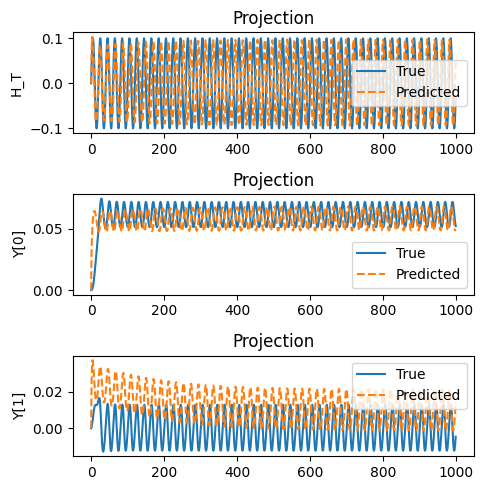

In [58]:
losses = []
whole_losses = []
best_loss = 100.0
for i in range(1000):
   
    optimizer.zero_grad()
    
    init,batch_t,truth = get_batch(train,time_train,24)
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.huber_loss(pred_y, truth)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/domain_best_single_field_deeper_onlylrelu_00pos_1000timesteps_3.pth')
    if i % 100 == 0:
        
        with torch.no_grad():
            pred_y = adjoint(model, train[0], time_train,method='dopri5')
            loss = F.huber_loss(pred_y, train)
            whole_losses.append(loss.item())
            
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            z_pred = pred_y[:,2].cpu()

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            z_train = train[:,2].cpu()

            fig, ax = plt.subplots(3, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('H_T')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y[0]')
            ax[1].set_title('Projection')
            ax[1].legend()

            ax[2].plot(z_train, label='True')
            ax[2].plot(z_pred, label='Predicted',linestyle='--')
            ax[2].set_ylabel('Y[1]')
            
            ax[2].set_title('Projection')
            ax[2].legend()

            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

In [59]:
print(best_loss)

1.3390100193330568e-06


In [60]:
test_model = DWODE_1().double().to(device)

In [61]:
test_model.load_state_dict(torch.load('saved_models\domain_best_single_field_deeper_onlylrelu_00pos_1000timesteps_3.pth'))

<All keys matched successfully>

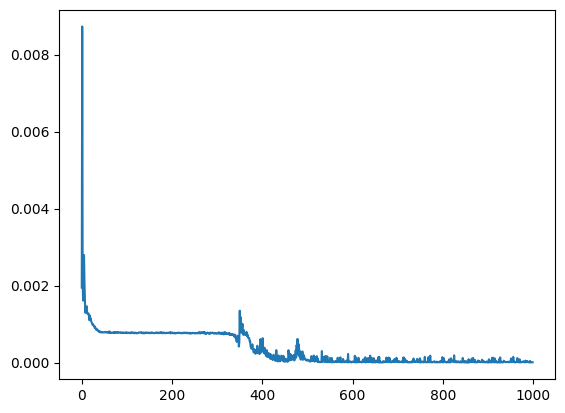

In [62]:
plt.plot(losses)
plt.show()

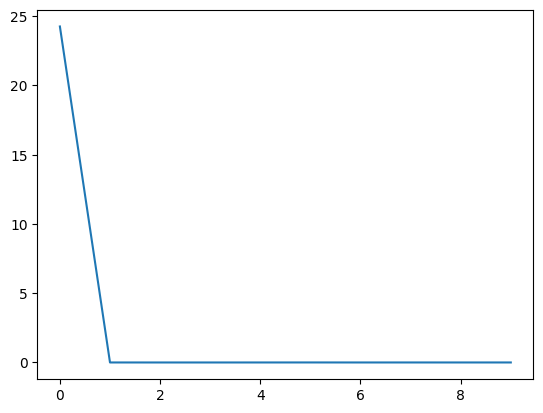

In [63]:
plt.plot(whole_losses)
plt.show()

In [64]:
with torch.no_grad():
    pred = adjoint(test_model, train[0], time,method='dopri5')
  

In [65]:
pred = pred.cpu().detach().numpy()

In [66]:
pred.shape,data.shape

((1000, 3), torch.Size([3, 1000]))

In [67]:
data = data.transpose(0,1)

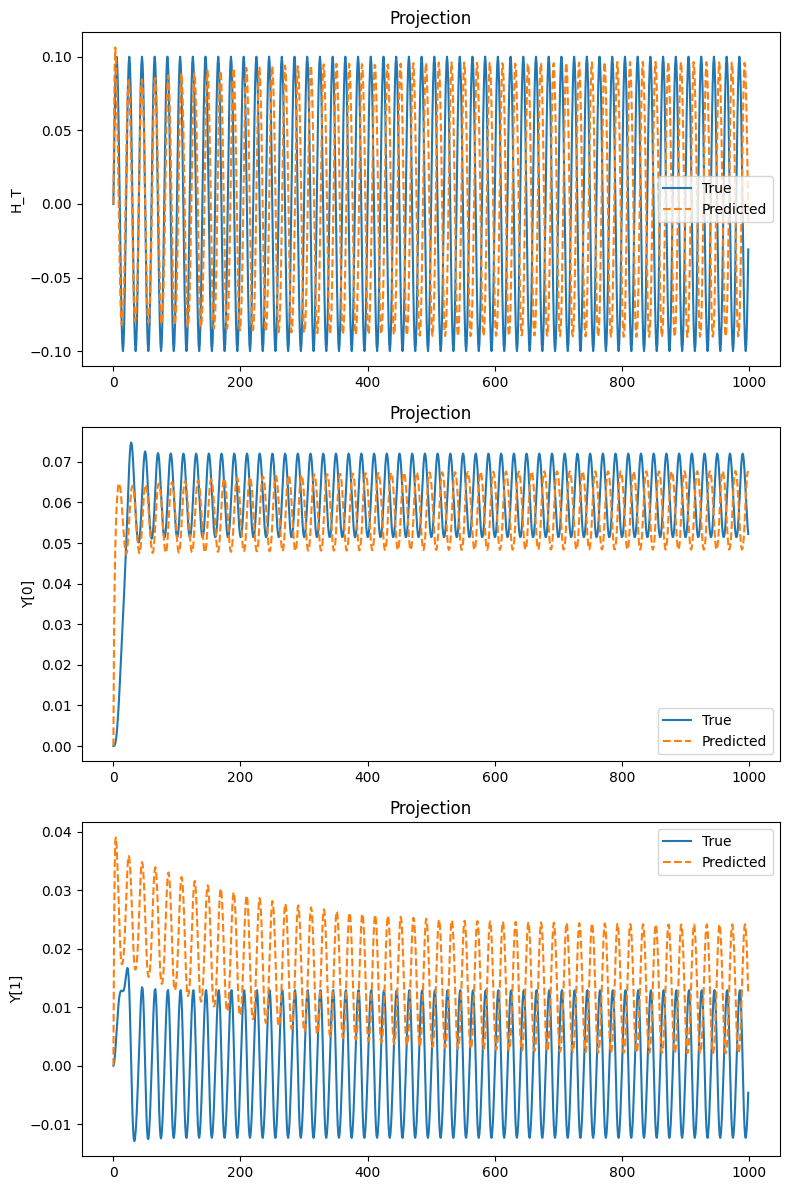

In [68]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]
z_pred = pred[:,2]

# Extract the x, y, z coordinates from X_train_plt
x_train = data[:,0].cpu()
y_train = data[:,1].cpu()
z_train = data[:,2].cpu()

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Y[1]')
ax[2].set_title('Projection')
ax[2].legend()
plt.savefig('projection_full_1_batch_lrelu_00pos_start_deeper_6_1000timesteps.png')
plt.tight_layout()
plt.show()

In [69]:
t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [60.0,0.0])

[100.]
[100.]


In [70]:
time_train = torch.tensor(t_).to(device)

In [71]:
h_t_ = torch.tensor(ht, dtype=torch.float64)  # Converting to column vector
y_0_ = torch.tensor(y_[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(h_t_, 1000.),torch.div(y_0_, 1000.),y_1_)).to(device)

In [72]:
train = data_[:,:].transpose(0,1)

In [73]:
test_model = DWODE_1().double().to(device)

In [74]:
test_model.load_state_dict(torch.load('saved_models\domain_best_single_field_deeper_onlylrelu_00pos_1000timesteps_3.pth'))

<All keys matched successfully>

In [75]:
with torch.no_grad():
    pred = adjoint(test_model, train[0], time,method='dopri5')
  

In [76]:
pred = pred.cpu().detach().numpy()

In [77]:
data = data.transpose(0,1)

In [78]:
pred.shape,data.shape

((1000, 3), torch.Size([3, 1000]))

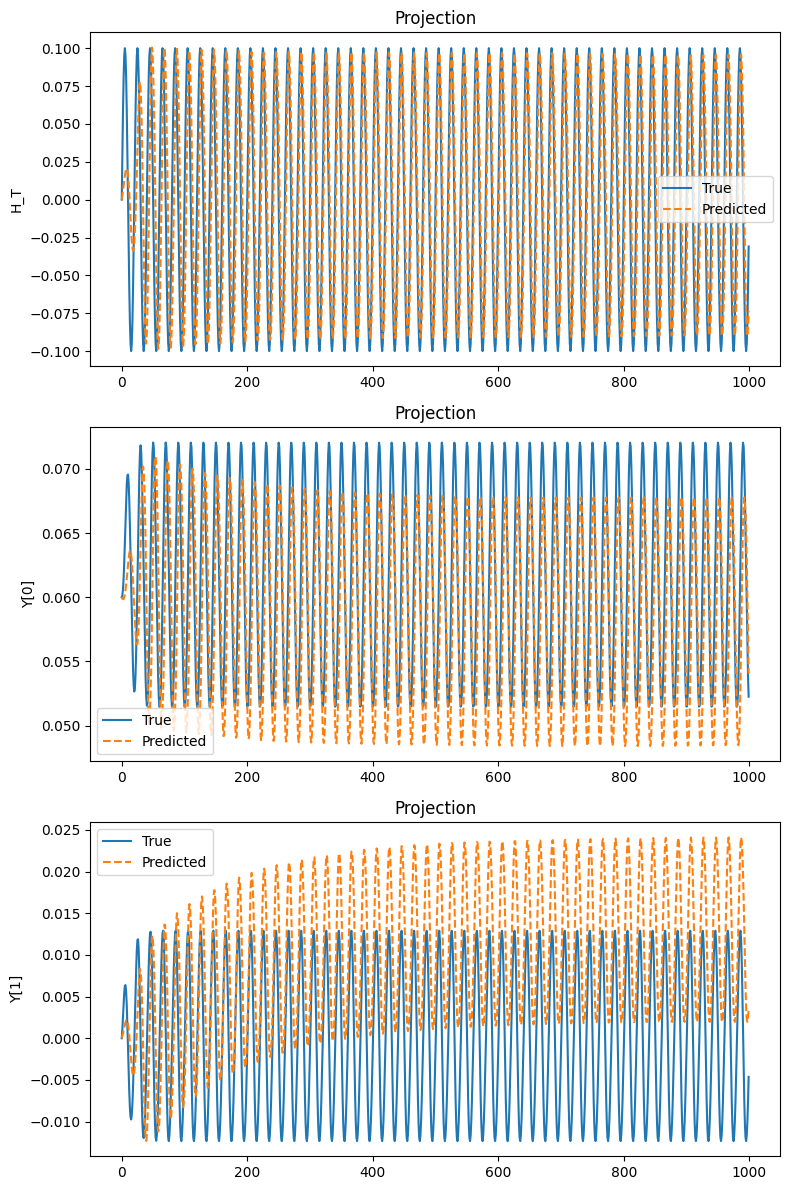

In [80]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]
z_pred = pred[:,2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()
z_train = train[:,2].cpu()

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Y[1]')
ax[2].set_title('Projection')
ax[2].legend()
plt.savefig('projection_full_1_batch_lrelu_60pos_start_deeper_6_1000timesteps.png')
plt.tight_layout()
plt.show()